In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.math import confusion_matrix

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 2000)

In [2]:
# Define integer encoding for the 6 classes:
activity_to_code = {'dws': 0, 'ups': 1, 'sit': 2, 'std': 3, 'wlk': 4, 'jog': 5}
code_to_activity = {v:k for k,v in activity_to_code.items()}

# Load data

In [3]:
df = pd.read_csv(r'../processed_data_100_25.csv')
# df = pd.read_csv(r'../processed_data_100_50.csv')
# df = pd.read_csv(r'../processed_data_200_50.csv')
# df = pd.read_csv(r'../processed_data_200_100.csv')
# df = pd.read_csv(r'../processed_data_300_75.csv')
# df = pd.read_csv(r'../processed_data_300_150.csv')

df = df.drop(columns = ['index_range', 'subject', 'experiment'])

# Convert labels to numbers
df = df.replace(activity_to_code)

# Shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,attitude.roll_min,attitude.roll_max,attitude.roll_median,attitude.roll_std,attitude.roll_skew,attitude.pitch_min,attitude.pitch_max,attitude.pitch_median,attitude.pitch_std,attitude.pitch_skew,attitude.yaw_min,attitude.yaw_max,attitude.yaw_median,attitude.yaw_std,attitude.yaw_skew,gravity.x_min,gravity.x_max,gravity.x_median,gravity.x_std,gravity.x_skew,gravity.y_min,gravity.y_max,gravity.y_median,gravity.y_std,gravity.y_skew,gravity.z_min,gravity.z_max,gravity.z_median,gravity.z_std,gravity.z_skew,rotationRate.x_min,rotationRate.x_max,rotationRate.x_median,rotationRate.x_std,rotationRate.x_skew,rotationRate.y_min,rotationRate.y_max,rotationRate.y_median,rotationRate.y_std,rotationRate.y_skew,rotationRate.z_min,rotationRate.z_max,rotationRate.z_median,rotationRate.z_std,rotationRate.z_skew,userAcceleration.x_min,userAcceleration.x_max,userAcceleration.x_median,userAcceleration.x_std,userAcceleration.x_skew,userAcceleration.y_min,userAcceleration.y_max,userAcceleration.y_median,userAcceleration.y_std,userAcceleration.y_skew,userAcceleration.z_min,userAcceleration.z_max,userAcceleration.z_median,userAcceleration.z_std,userAcceleration.z_skew,attitude.roll_max_amp,attitude.roll_main_freq,attitude.roll_num_freq,attitude.pitch_max_amp,attitude.pitch_main_freq,attitude.pitch_num_freq,attitude.yaw_max_amp,attitude.yaw_main_freq,attitude.yaw_num_freq,gravity.x_max_amp,gravity.x_main_freq,gravity.x_num_freq,gravity.y_max_amp,gravity.y_main_freq,gravity.y_num_freq,gravity.z_max_amp,gravity.z_main_freq,gravity.z_num_freq,rotationRate.x_max_amp,rotationRate.x_main_freq,rotationRate.x_num_freq,rotationRate.y_max_amp,rotationRate.y_main_freq,rotationRate.y_num_freq,rotationRate.z_max_amp,rotationRate.z_main_freq,rotationRate.z_num_freq,userAcceleration.x_max_amp,userAcceleration.x_main_freq,userAcceleration.x_num_freq,userAcceleration.y_max_amp,userAcceleration.y_main_freq,userAcceleration.y_num_freq,userAcceleration.z_max_amp,userAcceleration.z_main_freq,userAcceleration.z_num_freq,activity
0,0.574537,0.574537,0.574537,0.000000e+00,0.000000,0.004472,0.012968,0.008683,0.002491,0.012156,0.099757,0.099757,0.099757,2.789540e-17,0.000000,0.427807,0.427807,0.427807,5.579081e-17,0.000000,0.614159,0.614159,0.614159,0.000000e+00,0.0,0.000433,0.001585,0.000565,3.333879e-04,1.128946,-0.011424,0.015742,0.003243,0.008002,-0.237662,-0.021325,0.012159,-0.009670,0.008805,0.497184,-0.039133,0.052107,0.004594,0.023238,0.233166,0.000569,0.001642,0.001087,3.145819e-04,0.050037,-0.003318,-0.002262,-0.002813,3.095393e-04,0.063102,-0.011880,-0.010819,-0.011373,3.109536e-04,0.063102,57.453699,0,1,0.869579,0,50,9.975658,0,1,42.780692,0,1,61.415873,0,1,0.072594,0,54,0.329496,0,42,0.326148,6,50,0.861456,1,51,0.109313,0,50,0.016989,2,49,0.017066,2,49,2
1,1.024006,1.024006,1.024006,4.919724e-16,0.000000,-0.141512,0.012192,-0.067513,0.054398,0.039015,0.494479,0.494479,0.494479,2.539554e-16,0.000000,0.277836,0.277836,0.277836,1.146090e-16,0.000000,0.927046,0.927046,0.927046,5.208603e-16,0.0,-0.117694,0.055293,-0.028474,6.068590e-02,-0.034070,-0.375837,0.376294,0.011376,0.266755,-0.039790,-0.745945,0.745430,0.023346,0.526692,-0.035916,-0.231161,0.231442,0.006997,0.164069,-0.039790,-0.127462,0.124497,-0.005002,6.638305e-02,-0.018045,-0.014121,0.129799,0.059972,5.104353e-02,-0.039790,-0.039211,0.258491,0.114052,1.055848e-01,-0.039790,102.400580,0,48,1.837955,3,50,49.447926,0,41,27.783606,0,45,92.704635,0,41,0.226365,1,42,9.772018,8,50,1.826940,1,43,6.010341,8,50,1.838400,15,51,5.893411,0,50,11.190493,0,50,4
2,-0.151854,0.265217,0.073353,1.262680e-01,-0.105722,-0.087842,0.136652,0.027038,0.061875,0.048285,1.169931,1.169931,1.169931,2.231632e-16,0.000000,-0.088248,0.026334,-0.030787,3.315615e-02,0.053129,0.901853,0.901853,0.901853,0.000000e+00,0.0,0.170611,0.170611,0.170611,0.000000e+00,0.000000,-0.095291,0.772050,0.373014,0.241478,-0.086331,-0.680936,0.984570,-0.004868,0.407830,0.487892,-1.935844,1.679727,-0.030512,0.911445,-0.174375,-0.330954,0.288417,-0.006762,1.168780e-

# Create MLP model

In [4]:
MLP = keras.Sequential([
    keras.layers.Dense(96, input_shape=(96,), activation='relu'),  # input layer (1)
    keras.layers.Dense(48, activation='relu'),# hidden layer (2)
    keras.layers.Dense(6, activation='softmax') # output layer (3)
])

In [5]:
MLP.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                9312      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                4656      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 294       
Total params: 14,262
Trainable params: 14,262
Non-trainable params: 0
_________________________________________________________________


# Train MLP model with stratifiedKfold cross validation

In [7]:
label = df.pop('activity').to_numpy()
data = df.to_numpy()

skf = StratifiedKFold(5)

In [8]:
print(data.shape)
print(label.shape)

(55247, 96)
(55247,)


In [9]:
accuracies = []
matrixes = []
attempt = 1

initial_weights = MLP.get_weights()
for train_index, test_index in skf.split(data, label):
    # reset model weights
    MLP.set_weights(initial_weights)
    
    print("TRAIN ATTEMPT: ", attempt)
    attempt = attempt + 1
    
    # Split data into train and test
    train, train_label = data[train_index], label[train_index]
    test, test_label = data[test_index], label[test_index]
    
    # Train model
    MLP.fit(train, train_label, epochs=5)

    # Record evaluation accuracy
    eval_loss, eval_acc = MLP.evaluate(test, test_label, verbose=1)
    accuracies.append(eval_acc)

    # Record confusion matrix
    predict_label = MLP.predict_classes(test)
    matrix = confusion_matrix(labels=test_label, predictions=predict_label).numpy()
    matrixes.append(matrix)
    
    

accuracies = np.around(accuracies, decimals = 4)
print("Accuracy values: ", accuracies)
print("Average accuracy: ", np.mean(accuracies))

TRAIN ATTEMPT:  1
Epoch 1/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.4169 - accuracy: 0.8913
Epoch 2/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.1134 - accuracy: 0.9612
Epoch 3/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.0859 - accuracy: 0.9697
Epoch 4/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.0649 - accuracy: 0.9778
Epoch 5/5
346/346 [==============================] - 0s 902us/step - loss: 0.0339 - accuracy: 0.9889
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
TRAIN ATTEMPT:  2
Epoch 1/5
1382/1382 [==============================] - 2s 1ms/step - loss: 0.3047 - accuracy: 0.9096
Epoch 2/5
1382/1382 [===

# Inspect Confustion Matrix

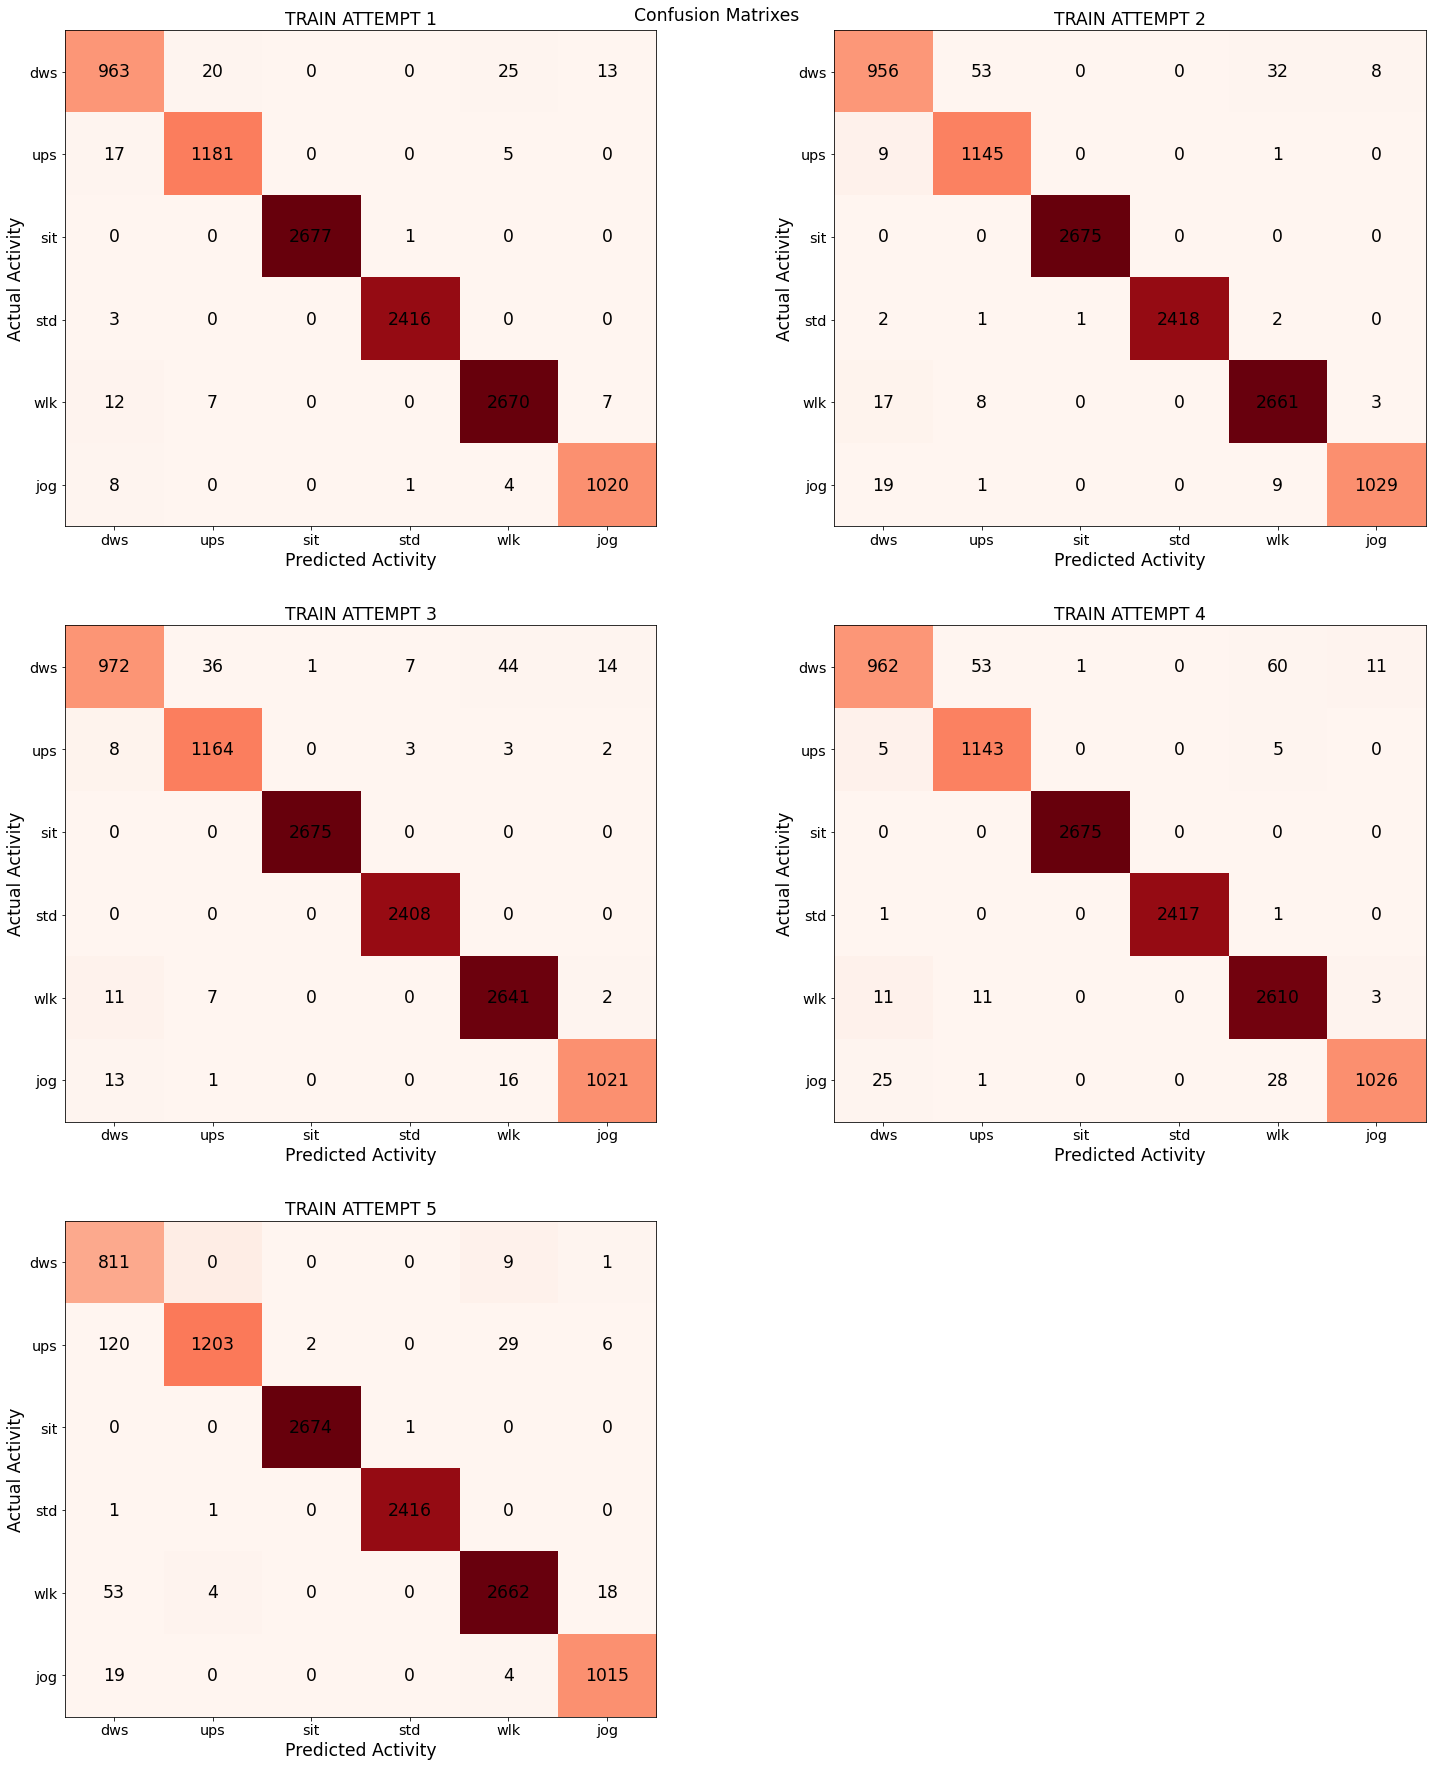

In [10]:
activities = ['dws', 'dws', 'ups', 'sit', 'std', 'wlk', 'jog']

fig = plt.figure(figsize = (20,25))
fig.suptitle("Confusion Matrixes", fontsize = "xx-large")

for index, m in enumerate(matrixes):
    sp = fig.add_subplot(3,2,index + 1)
    sp.imshow(m, cmap="Reds", aspect='auto')
    sp.set_title("TRAIN ATTEMPT " + str(index + 1), fontsize = "xx-large")

    for i in range(6):
        for j in range(6):
            sp.text(i, j, m[i, j], ha="center", va="center", color="black", fontsize = "xx-large")

    sp.set_xticklabels(activities, fontsize = "x-large")
    sp.set_yticklabels(activities, fontsize = "x-large")
    
    sp.set_ylabel("Actual Activity", fontsize = "xx-large")
    sp.set_xlabel("Predicted Activity", fontsize = "xx-large")

fig.tight_layout()
fig.subplots_adjust(wspace = 0.3, hspace = 0.2)
plt.show()

In [11]:
weights = np.array(MLP.get_weights())

# Export weights as text file

In [12]:
# export weights of each layer
for index, list in enumerate(weights):
    print("\n")
    print(list)
    np.savetxt("weight" + str(index) + ".txt", list, fmt='%.10f')



[[-0.05354011  0.33327058  0.14545487 ...  0.43826404  0.3674302
  -0.387118  ]
 [ 0.09585685 -0.22934373 -0.04880567 ... -0.27332133 -0.48263514
   0.19007261]
 [ 0.00858648 -0.09930819  0.03393801 ...  0.35003632  0.03085709
  -0.24671921]
 ...
 [-0.11200504 -0.2908651   0.07541727 ...  0.15921052  0.4734448
  -0.10288358]
 [-0.23667678 -0.06328171 -0.23717874 ...  0.05093503 -0.16850427
   0.15180029]
 [ 0.08543556  0.10742976 -0.097568   ... -0.04309445 -0.14796975
   0.10374977]]


[ 0.00299058 -0.01352031 -0.03845772  0.00523708  0.14745481 -0.01881978
 -0.02549862 -0.06606464 -0.01525249 -0.08126561 -0.03221507 -0.0528114
  0.08030526  0.05889868 -0.05495083 -0.01192436 -0.04329789  0.00133411
 -0.00394694 -0.02631631  0.04639195  0.05616377 -0.06352507 -0.07680689
  0.02152693  0.03242642  0.00446004  0.03205098  0.04338982  0.05817446
 -0.03132643 -0.03174505  0.01510399  0.02609608 -0.02375083 -0.08374812
 -0.03172114 -0.05569948  0.13271347 -0.01870812 -0.01904878  0.01386